In [1]:
from train_latent_space import (
    BRepDS, 
    BRepFaceAutoencoder, 
    BRepFaceEncoder, 
    implicit_part_to_data, 
    ImplicitPart, 
    ImplicitDecoder
)
import meshplot as mp
from pspy import Part, PartOptions
import numpy as np
import torch
from torch_geometric.transforms import SamplePoints
from torch_geometric.data import Data as TGData
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from chamferdist import ChamferDistance

In [2]:
data_root = '/media/ben/Data/cad'
model_checkpoint_path = data_root + '/BRepFaceAutoencoder_64_1024_4.ckpt'
cube_path = data_root + '/cubes/cube.x_t'
long_cube_path = data_root + '/cubes/long_cube.x_t'
angled_cube_path = data_root + '/cubes/angled_cube.x_t'

In [26]:
# Stolen from pytorch3d, and tweaked (very little).

# Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.

import warnings
from collections import namedtuple
from typing import Optional, Union

import torch

# Throws an error without this import
from chamferdist import _C
from torch.autograd import Function
from torch.autograd.function import once_differentiable


_KNN = namedtuple("KNN", "dists idx knn")


class WeightedChamferDistance(torch.nn.Module):
    def __init__(self, sharpness=1):
        super(WeightedChamferDistance, self).__init__()
        self.sharpness = sharpness
        
    def forward(
        self,
        source_cloud: torch.Tensor,
        target_cloud: torch.Tensor
    ):

        if not isinstance(source_cloud, torch.Tensor):
            raise TypeError(
                "Expected input type torch.Tensor. Got {} instead".format(type(pts))
            )
        if not isinstance(target_cloud, torch.Tensor):
            raise TypeError(
                "Expected input type torch.Tensor. Got {} instead".format(type(pts))
            )
        if source_cloud.device != target_cloud.device:
            raise ValueError(
                "Source and target clouds must be on the same device. "
                f"Got {source_cloud.device} and {target_cloud.device}."
            )

        source_weights = torch.sigmoid(-self.sharpness * source_cloud[:,:,-1])
        source_cloud = source_cloud[:,:,:-1]
        batchsize_source, lengths_source, dim_source = source_cloud.shape
        batchsize_target, lengths_target, dim_target = target_cloud.shape

        lengths_source = (
            torch.ones(batchsize_source, dtype=torch.long, device=source_cloud.device)
            * lengths_source
        )
        lengths_target = (
            torch.ones(batchsize_target, dtype=torch.long, device=target_cloud.device)
            * lengths_target
        )

        chamfer_dist = None

        if batchsize_source != batchsize_target:
            raise ValueError(
                "Source and target pointclouds must have the same batchsize."
            )
        if dim_source != dim_target:
            raise ValueError(
                "Source and target pointclouds must have the same dimensionality."
            )

        source_nn = knn_points(
            source_cloud,
            target_cloud,
            lengths1=lengths_source,
            lengths2=lengths_target,
            K=1,
        )

        target_nn = knn_points(
            target_cloud,
            source_cloud,
            lengths1=lengths_target,
            lengths2=lengths_source,
            K=1,
        )

        # Forward Chamfer distance (batchsize_source, lengths_source)
        chamfer_forward = source_nn.dists[..., 0]
        # Backward Chamfer distance (batchsize_source, lengths_source)
        chamfer_backward = target_nn.dists[..., 0]

        # Do weighted instead
        weights_forward = source_weights
        weights_backward = source_weights.flatten()[target_nn.idx[..., 0]]

        chamfer_forward = weights_forward*chamfer_forward # Per Blue
        chamfer_backward = (2-weights_backward)*chamfer_backward # Per Red
        just_weights_backwards = (1-weights_backward)
        chamfer_backward = .005 * just_weights_backwards + chamfer_backward

        chamfer_forward = chamfer_forward.sum(1)  # (batchsize_source,)
        chamfer_backward = chamfer_backward.sum(1)  # (batchsize_target,)

        chamfer_forward = chamfer_forward.mean()  # (1,)
        chamfer_backward = chamfer_backward.mean()  # (1,)

        return chamfer_forward + chamfer_backward


class _knn_points(Function):
    """
    Torch autograd Function wrapper for KNN C++/CUDA implementations.
    """

    @staticmethod
    def forward(
        ctx, p1, p2, lengths1, lengths2, K, version, return_sorted: bool = True
    ):
        """
        K-Nearest neighbors on point clouds.
        Args:
            p1: Tensor of shape (N, P1, D) giving a batch of N point clouds, each
                containing up to P1 points of dimension D.
            p2: Tensor of shape (N, P2, D) giving a batch of N point clouds, each
                containing up to P2 points of dimension D.
            lengths1: LongTensor of shape (N,) of values in the range [0, P1], giving the
                length of each pointcloud in p1. Or None to indicate that every cloud has
                length P1.
            lengths2: LongTensor of shape (N,) of values in the range [0, P2], giving the
                length of each pointcloud in p2. Or None to indicate that every cloud has
                length P2.
            K: Integer giving the number of nearest neighbors to return.
            version: Which KNN implementation to use in the backend. If version=-1,
                the correct implementation is selected based on the shapes of the inputs.
            return_sorted: (bool) whether to return the nearest neighbors sorted in
                ascending order of distance.
        Returns:
            p1_dists: Tensor of shape (N, P1, K) giving the squared distances to
                the nearest neighbors. This is padded with zeros both where a cloud in p2
                has fewer than K points and where a cloud in p1 has fewer than P1 points.
            p1_idx: LongTensor of shape (N, P1, K) giving the indices of the
                K nearest neighbors from points in p1 to points in p2.
                Concretely, if `p1_idx[n, i, k] = j` then `p2[n, j]` is the k-th nearest
                neighbors to `p1[n, i]` in `p2[n]`. This is padded with zeros both where a cloud
                in p2 has fewer than K points and where a cloud in p1 has fewer than P1 points.
        """

        # pyre-fixme[16]: Module `pytorch3d` has no attribute `_C`.
        idx, dists = _C.knn_points_idx(p1, p2, lengths1, lengths2, K, version)

        # sort KNN in ascending order if K > 1
        if K > 1 and return_sorted:
            if lengths2.min() < K:
                P1 = p1.shape[1]
                mask = lengths2[:, None] <= torch.arange(K, device=dists.device)[None]
                # mask has shape [N, K], true where dists irrelevant
                mask = mask[:, None].expand(-1, P1, -1)
                # mask has shape [N, P1, K], true where dists irrelevant
                dists[mask] = float("inf")
                dists, sort_idx = dists.sort(dim=2)
                dists[mask] = 0
            else:
                dists, sort_idx = dists.sort(dim=2)
            idx = idx.gather(2, sort_idx)

        ctx.save_for_backward(p1, p2, lengths1, lengths2, idx)
        ctx.mark_non_differentiable(idx)
        return dists, idx

    @staticmethod
    @once_differentiable
    def backward(ctx, grad_dists, grad_idx):
        p1, p2, lengths1, lengths2, idx = ctx.saved_tensors
        # TODO(gkioxari) Change cast to floats once we add support for doubles.
        if not (grad_dists.dtype == torch.float32):
            grad_dists = grad_dists.float()
        if not (p1.dtype == torch.float32):
            p1 = p1.float()
        if not (p2.dtype == torch.float32):
            p2 = p2.float()
        grad_p1, grad_p2 = _C.knn_points_backward(
            p1, p2, lengths1, lengths2, idx, grad_dists
        )
        return grad_p1, grad_p2, None, None, None, None, None


def knn_points(
    p1: torch.Tensor,
    p2: torch.Tensor,
    lengths1: Union[torch.Tensor, None] = None,
    lengths2: Union[torch.Tensor, None] = None,
    K: int = 1,
    version: int = -1,
    return_nn: bool = False,
    return_sorted: bool = True,
):
    """
    K-Nearest neighbors on point clouds.
    Args:
        p1: Tensor of shape (N, P1, D) giving a batch of N point clouds, each
            containing up to P1 points of dimension D.
        p2: Tensor of shape (N, P2, D) giving a batch of N point clouds, each
            containing up to P2 points of dimension D.
        lengths1: LongTensor of shape (N,) of values in the range [0, P1], giving the
            length of each pointcloud in p1. Or None to indicate that every cloud has
            length P1.
        lengths2: LongTensor of shape (N,) of values in the range [0, P2], giving the
            length of each pointcloud in p2. Or None to indicate that every cloud has
            length P2.
        K: Integer giving the number of nearest neighbors to return.
        version: Which KNN implementation to use in the backend. If version=-1,
            the correct implementation is selected based on the shapes of the inputs.
        return_nn: If set to True returns the K nearest neighbors in p2 for each point in p1.
        return_sorted: (bool) whether to return the nearest neighbors sorted in
            ascending order of distance.
    Returns:
        dists: Tensor of shape (N, P1, K) giving the squared distances to
            the nearest neighbors. This is padded with zeros both where a cloud in p2
            has fewer than K points and where a cloud in p1 has fewer than P1 points.
        idx: LongTensor of shape (N, P1, K) giving the indices of the
            K nearest neighbors from points in p1 to points in p2.
            Concretely, if `p1_idx[n, i, k] = j` then `p2[n, j]` is the k-th nearest
            neighbors to `p1[n, i]` in `p2[n]`. This is padded with zeros both where a cloud
            in p2 has fewer than K points and where a cloud in p1 has fewer than P1
            points.
        nn: Tensor of shape (N, P1, K, D) giving the K nearest neighbors in p2 for
            each point in p1. Concretely, `p2_nn[n, i, k]` gives the k-th nearest neighbor
            for `p1[n, i]`. Returned if `return_nn` is True.
            The nearest neighbors are collected using `knn_gather`
            .. code-block::
                p2_nn = knn_gather(p2, p1_idx, lengths2)
            which is a helper function that allows indexing any tensor of shape (N, P2, U) with
            the indices `p1_idx` returned by `knn_points`. The outout is a tensor
            of shape (N, P1, K, U).
    """
    if p1.shape[0] != p2.shape[0]:
        raise ValueError("pts1 and pts2 must have the same batch dimension.")
    if p1.shape[2] != p2.shape[2]:
        raise ValueError("pts1 and pts2 must have the same point dimension.")

    p1 = p1.contiguous()
    p2 = p2.contiguous()

    P1 = p1.shape[1]
    P2 = p2.shape[1]

    if lengths1 is None:
        lengths1 = torch.full((p1.shape[0],), P1, dtype=torch.int64, device=p1.device)
    if lengths2 is None:
        lengths2 = torch.full((p1.shape[0],), P2, dtype=torch.int64, device=p1.device)

    # pyre-fixme[16]: `_knn_points` has no attribute `apply`.
    p1_dists, p1_idx = _knn_points.apply(
        p1, p2, lengths1, lengths2, K, version, return_sorted
    )

    p2_nn = None
    if return_nn:
        p2_nn = knn_gather(p2, p1_idx, lengths2)

    return _KNN(dists=p1_dists, idx=p1_idx, knn=p2_nn if return_nn else None)


def knn_gather(
    x: torch.Tensor, idx: torch.Tensor, lengths: Union[torch.Tensor, None] = None
):
    """
    A helper function for knn that allows indexing a tensor x with the indices `idx`
    returned by `knn_points`.
    For example, if `dists, idx = knn_points(p, x, lengths_p, lengths, K)`
    where p is a tensor of shape (N, L, D) and x a tensor of shape (N, M, D),
    then one can compute the K nearest neighbors of p with `p_nn = knn_gather(x, idx, lengths)`.
    It can also be applied for any tensor x of shape (N, M, U) where U != D.
    Args:
        x: Tensor of shape (N, M, U) containing U-dimensional features to
            be gathered.
        idx: LongTensor of shape (N, L, K) giving the indices returned by `knn_points`.
        lengths: LongTensor of shape (N,) of values in the range [0, M], giving the
            length of each example in the batch in x. Or None to indicate that every
            example has length M.
    Returns:
        x_out: Tensor of shape (N, L, K, U) resulting from gathering the elements of x
            with idx, s.t. `x_out[n, l, k] = x[n, idx[n, l, k]]`.
            If `k > lengths[n]` then `x_out[n, l, k]` is filled with 0.0.
    """
    N, M, U = x.shape
    _N, L, K = idx.shape

    if N != _N:
        raise ValueError("x and idx must have same batch dimension.")

    if lengths is None:
        lengths = torch.full((x.shape[0],), M, dtype=torch.int64, device=x.device)

    idx_expanded = idx[:, :, :, None].expand(-1, -1, -1, U)
    # idx_expanded has shape [N, L, K, U]

    x_out = x[:, :, None].expand(-1, -1, K, -1).gather(1, idx_expanded)
    # p2_nn has shape [N, L, K, U]

    needs_mask = lengths.min() < K
    if needs_mask:
        # mask has shape [N, K], true where idx is irrelevant because
        # there is less number of points in p2 than K
        mask = lengths[:, None] <= torch.arange(K, device=x.device)[None]

        # expand mask to shape [N, L, K, U]
        mask = mask[:, None].expand(-1, L, -1)
        mask = mask[:, :, :, None].expand(-1, -1, -1, U)
        x_out[mask] = 0.0

    return x_out


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/ben/anaconda3/envs/automate/lib/python3.9/site-packages/jupyter_client/session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.002746…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.045408…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.016465…

2

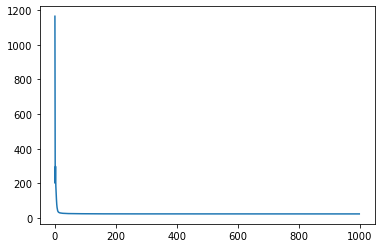

In [27]:
weighted = True
num_iters = 1000


sampler = SamplePoints(6*1000)

chamferDist = WeightedChamferDistance(sharpness=2) if weighted else ChamferDistance()
opts = PartOptions()
opts.normalize = True
angled_part = Part(angled_cube_path, opts)
angled_V = torch.from_numpy(2*angled_part.mesh.V)
angled_F = torch.from_numpy(angled_part.mesh.F).T.long()
angled_data = TGData(pos=angled_V, face=angled_F)
sampler(angled_data)
target_pc = angled_data.pos
target = target_pc.unsqueeze(0).float().cuda()

ipart = ImplicitPart(cube_path, 10, 100, True)
data = implicit_part_to_data(ipart, 10).cuda()
data.face_surfaces = data.face_surfaces.float()
data.face_surfaces.requires_grad = True
data.edge_curves = data.edge_curves.float()
data.edge_curves.requires_grad = True
data.vertex_positions.requires_grad = True
data.face_surface_parameters.requires_grad = True
data.edge_curve_parameters.requires_grad = True

model = BRepFaceAutoencoder(64,1024,4)
ckpt = torch.load(model_checkpoint_path)
model.load_state_dict(ckpt['state_dict'])

n_faces = 6
N = 50
line = torch.linspace(-0.1,1.1,N)
grid = torch.cartesian_prod(line, line)
grids = grid.repeat(n_faces,1)
indices = torch.arange(n_faces).repeat_interleave(N*N, dim=0)


model = model.cuda()
grids = grids.cuda()
indices = indices.cuda()

opt = torch.optim.SGD(
    [
        data.face_surfaces,
        data.edge_curves,
        data.edge_curve_parameters,
        data.vertex_positions,
        data.face_surface_parameters
    ], 
    lr=0.001, 
    momentum=0.5)

losses = []
predictions = []


for iter in tqdm(range(num_iters)):
    opt.zero_grad()
    pred = model(data, grids, indices)
    pred_xyz = pred[:,:3].unsqueeze(0).float()
    pred_m = pred[:,3].unsqueeze(0).float()
    loss = chamferDist(pred.unsqueeze(0).float(), target) if weighted else chamferDist(pred_xyz, target) + chamferDist(target, pred_xyz)
    loss.backward()
    opt.step()
    losses.append(loss.detach().item())
    predictions.append((pred_xyz.detach().cpu().numpy(), pred_m.detach().cpu().numpy()))
    #print(loss)
plt.plot(losses)
i = 0
plot1 = mp.plot(
    predictions[i][0][0,:,:],
    c=predictions[i][1][0,:],
    shading={'point_size':0.1},
    return_plot = True)
plot1.add_points(target_pc.numpy(), shading={'point_size':0.1, 'point_color':'red'})

i = num_iters - 1
plot2 =mp.plot(
    predictions[i][0][0,:,:],
    c=predictions[i][1][0,:],
    shading={'point_size':0.1},
    return_plot=True)
plot2.add_points(target_pc.numpy(), shading={'point_size':0.1, 'point_color':'red'})

i = num_iters - 1
sdf = predictions[i][1][0,:]
xyz = predictions[i][0][0,sdf<=0, :]
plot3 =mp.plot(
    xyz,
    shading={'point_size':0.1, 'point_color':'blue'},
    return_plot=True)
plot2.add_points(target_pc.numpy(), shading={'point_size':0.1, 'point_color':'red'})

In [16]:
xyz.shape

(10686, 3)

In [5]:
import math
import OCC.Core.BRepBuilderAPI as BRepBuilderAPI
import OCC.Core.Geom as Geom
from OCC.Core.GeomAPI import GeomAPI_IntSS, GeomAPI_ExtremaCurveCurve, GeomAPI_ProjectPointOnCurve
from OCC.Core.Extrema import Extrema_POnCurv
from OCC.Core.gp import gp_Pnt, gp_Lin, gp_Ax1, gp_Dir, gp_Elips, gp_Ax2, gp_Ax3
from OCC.Core.BRepBuilderAPI import (
    BRepBuilderAPI_MakeEdge, 
    BRepBuilderAPI_MakeVertex, 
    BRepBuilderAPI_MakeFace,
    BRepBuilderAPI_MakeWire,
    BRepBuilderAPI_MakeShell,
    BRepBuilderAPI_MakeSolid   
)
from OCC.Core.BRep import BRep_Builder
from OCC.Core.TColgp import TColgp_Array1OfPnt
from OCC.Core.Geom import Geom_BezierCurve
from OCC.Display.WebGl.jupyter_renderer import JupyterRenderer
from OCC.Core.TopoDS import TopoDS_Shell, TopoDS_Face, TopoDS_Solid

from OCC.Core.STEPControl import STEPControl_Writer, STEPControl_AsIs
from OCC.Core.IFSelect import IFSelect_RetDone

In [6]:
from OCC.Core.gp import (
    gp_Ax1,
    gp_Ax3,
    gp_Dir,
    gp_Pnt
)
from OCC.Core.Geom import (
    Geom_Plane,
    Geom_CylindricalSurface,
    Geom_ConicalSurface,
    Geom_SphericalSurface,
    Geom_ToroidalSurface,
    Geom_Line,
    Geom_Circle,
    Geom_Ellipse
)

from OCC.Core.BRep import (
    BRep_Builder
)

from OCC.Core.BRepBuilderAPI import (
    BRepBuilderAPI_MakeVertex,
    BRepBuilderAPI_MakeEdge,
    BRepBuilderAPI_MakeWire,
    BRepBuilderAPI_MakeFace
)

def make_surface(surface_type, params):

    cs = gp_Ax3(gp_Pnt(*params[:3]), gp_Dir(*params[3:6]), gp_Dir(*params[6:9]))

    radius       = params[9]
    major_radius = params[9]
    minor_radius = params[10]
    semi_angle   = params[10]

    if surface_type == 0:
        return Geom_Plane(cs)
    elif surface_type == 1:
        return Geom_CylindricalSurface(cs, radius)
    elif surface_type == 2:
        return Geom_ConicalSurface(cs, semi_angle, radius)
    elif surface_type == 3:
        return Geom_SphericalSurface(cs, radius)
    elif surface_type == 4:
        return Geom_ToroidalSurface(cs, major_radius, minor_radius)  

def make_curve(curve_type, params):

    loc   = gp_Pnt(*params[:3])
    z_dir = gp_Dir(*params[3:6])
    x_dir = gp_Dir(*params[6:9])
    cs = gp_Ax2(loc, z_dir, x_dir)
    radius = params[9]
    minor_radius = params[10]

    if curve_type == 0:
        return Geom_Line(gp_Ax1(loc, z_dir))
    elif curve_type == 1:
        return Geom_Circle(cs, radius)
    elif curve_type == 2:
        return Geom_Ellipse(cs, radius, minor_radius)

def reconstruct_geo(data, surfaces):
    return None, None # curves and points

def data_to_brep(data, reconstruct_geo=False):
    data = data.detach().cpu() # Ensure we have everything on the CPU without gradients
    # Create Geometry
    surfaces = [
        make_surface(t, data.face_surface_parameters[i].tolist()) 
        for i,t in enumerate(data.face_surfaces.argmax(dim=1))
        ]
    curves = [
        make_curve(t, data.edge_curve_parameters[i].tolist()) 
        for i,t in enumerate(data.edge_curves.argmax(dim=1))
        ]
    points = [gp_Pnt(*v.tolist()) for v in data.vertex_positions]

    # Now Construct the geometry bottom up
    vertices = [BRepBuilderAPI_MakeVertex(p).Vertex() for p in points]
    edge_vertices = {}
    for i,(e,v) in enumerate(data.edge_to_vertex.T):
        e = e.item()
        v = v.item()
        is_start = data.edge_to_vertex_is_start[i].item()
        edge_vertices[e] = edge_vertices.get(e,[]) + [(v,is_start)]
    edges = []
    for i in range(len(data.edge_curve_flipped)):
        flipped = data.edge_curve_flipped[i].item()
        verts = edge_vertices.get(i,[])
        if len(verts) == 0:
            edge = BRepBuilderAPI_MakeEdge(curves[i]).Edge()
            pass
        elif len(verts) == 1:
            edge = BRepBuilderAPI_MakeEdge(
                curves[i], 
                vertices[verts[0][0]], 
                vertices[verts[0][0]]).Edge()
        else:
            v1i,v1s = verts[0]
            v2i,v2s = verts[1]
            if flipped or v2s:
                v1i,v1s = verts[1]
                v2i,v2s = verts[0]
            v1 = vertices[v1i]
            v2 = vertices[v2i]
            build_edge = BRepBuilderAPI_MakeEdge(curves[i], v1, v2)
            edge = build_edge.Edge()
        if flipped:
            edge.Reverse()
        edges.append(edge)

    return edges,vertices

#data
data_to_brep(data)

RuntimeError: StdFail_NotDoneBRep_API: command not done raised from method Edge of class BRepBuilderAPI_MakeEdge

In [28]:
def recover_brep(data):
    data = data.detach().cpu()
    surface_types = data.face_surfaces.argmax(dim=1)
    def make_plane(params):
        return Geom.Geom_Plane(gp_Pnt(*params[:3]), gp_Dir(*params[3:6]))
    def make_geom(surface_type, params):
        if surface_type == 0:
            return make_plane(params)
        elif surface_type == 1:
            return make_cylinder(params)
        elif surface_type == 2:
            return make_cone(params)
        elif surface_type == 3:
            return make_sphere(params)
        elif surface_type == 4:
            return make_torus(params)
    surfaces = [make_geom(surface_types[i].item(), data.face_surface_parameters[i].tolist())
        for i in range(len(surface_types))
    ]
    # find and make the edges using surface intersections

    loop_faces = {}
    for i in range(data.face_to_loop.shape[1]):
        face = data.face_to_loop[0][i].item()
        loop = data.face_to_loop[1][i].item()
        loop_faces[loop] = face

    edge_faces = {}
    for i in range(data.loop_to_edge.shape[1]):
        loop = data.loop_to_edge[0][i].item()
        edge = data.loop_to_edge[1][i].item()
        edge_faces[edge] = edge_faces.get(edge,[]) + [loop_faces[loop]]

    curves = {}
    curve_types = {}
    for edge,[f1,f2] in edge_faces.items():
        intersection = GeomAPI_IntSS(surfaces[f1], surfaces[f2], 10e-16)
        assert(intersection.IsDone())
        curves[edge] = intersection.Line(1)
        curve_types[edge] = curves[edge].DynamicType().Name()
    data.edge_to_vertex
    vertex_edges = {}
    edge_vertices = {}
    edge_vertex_is_start = {}
    for i in range(data.edge_to_vertex.shape[1]):
        edge = data.edge_to_vertex[0][i].item()
        vertex = data.edge_to_vertex[1][i].item()
        vertex_edges[vertex] = vertex_edges.get(vertex,[]) + [edge]
        edge_vertices[edge] = edge_vertices.get(edge,[]) + [vertex]
        edge_vertex_is_start[edge] = edge_vertex_is_start.get(edge,[]) + [data.edge_to_vertex_is_start[i]]
    points = {}
    for v,cs in vertex_edges.items():
        if len(cs) < 2:
            continue
        extrema = GeomAPI_ExtremaCurveCurve(curves[cs[0]],curves[cs[1]])
        ext = extrema.Extrema()
        p1 = Extrema_POnCurv()
        p2 = Extrema_POnCurv()
        ext.Points(1,p1,p2)
        points[v] = p1.Value()
    vertices = {}
    for k,v in points.items():
        vertices[k] = BRepBuilderAPI_MakeVertex(v).Vertex()
    edges = {}
    for k,v in curves.items():
        if edge_vertex_is_start[k][0]:
            edges[k] = BRepBuilderAPI_MakeEdge(v,vertices[edge_vertices[k][0]], vertices[edge_vertices[k][1]]).Edge()
        else:
            edges[k] = BRepBuilderAPI_MakeEdge(v,vertices[edge_vertices[k][1]], vertices[edge_vertices[k][0]]).Edge()
    wire_edges = {}
    wire_edge_is_flipped = {}
    for i in range(data.loop_to_edge.shape[1]):
        loop = data.loop_to_edge[0][i].item()
        edge = data.loop_to_edge[1][i].item()
        wire_edges[loop] = wire_edges.get(loop,[]) + [edge]
        wire_edge_is_flipped[loop] = wire_edge_is_flipped.get(loop, []) + [data.loop_to_edge_flipped[i]]
    wires = {}
    for w, es in wire_edges.items():
        
        # data.loop_to_edge_flipped

        # Figure out a valid ordering for the edges in a loop.
        # I don't know if the order of vertices given to the make-edge
        # call does anything to determine which is start and which is end.
        # In the worst case, I can look at the parameters of the extrema
        # to choose which one to make the start, and which one to make the end,
        # then reverse things as necessary. The trick will be getting the orientations
        # to align with the original part versions.

        #wire = BRepBuilderAPI_MakeWire(*[edges[e] for e in es])
        wire = BRepBuilderAPI_MakeWire()
        for i,e in enumerate(es):
            if wire_edge_is_flipped[w][i]:
                wire.Add(edges[e].Reversed())
            else:
                wire.Add(edges[e])
        wires[w] = wire.Wire()
    face_loops = {}
    for i in range(data.face_to_loop.shape[1]):
        face = data.face_to_loop[0][i].item()
        loop = data.face_to_loop[1][i].item()
        face_loops[face] = face_loops.get(face, []) + [loop]
    faces = {}
    for k,v in face_loops.items():
        f = BRepBuilderAPI_MakeFace()
        f.Init(surfaces[k],False,10e-8)
        for w in v:
            f.Add(wires[w])
        f.Add(wires[0])
        faces[k] = f.Face()
    
    builder = BRep_Builder()
    shell = TopoDS_Shell()
    builder.MakeShell(shell)
    for f in faces.values():
        builder.Add(shell, f)
    solid = TopoDS_Solid()
    builder.MakeSolid(solid)
    builder.Add(solid, shell)

    return solid, shell, faces, wires, edges, vertices

def write_step(solid, filename):
    # Based On
    # https://cpp.hotexamples.com/examples/-/STEPControl_Writer/-/cpp-stepcontrol_writer-class-examples.html
    writer = STEPControl_Writer()
    status =writer.Transfer(solid, STEPControl_AsIs)
    writer.Write(filename)

def render_shapes(shapes):
    my_renderer = JupyterRenderer()
    for shape in shapes:
        my_renderer.DisplayShape(shape)
    return my_renderer.Display()



solid, shell, faces, wires, edges, vertices = recover_brep(data)


In [29]:
render_shapes(wires.values())


*******************************************************************
******        Statistics on Transfer (Write)                 ******

*******************************************************************
******        Transfer Mode = 0  I.E.  As Is       ******
******        Transferring Shape, ShapeType = 2                      ******


1

** WorkSession : Sending all data
 Step File Name : test_out.step(356 ents)  Write  Done


In [246]:
# Output looks like it has some flipped normals - didn't check face orientations

True

In [149]:
BRepBuilderAPI_MakeEdge(curves[0]).Edge()

<class 'TopoDS_Edge'>

/home/ben/anaconda3/envs/automate/lib/python3.9/site-packages/jupyter_client/session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


In [85]:
extrema = GeomAPI_ExtremaCurveCurve(curves[0], curves[1])
ext = extrema.Extrema()
p1 = OCC.Core.Extrema.Extrema_POnCurv()
p2 = OCC.Core.Extrema.Extrema_POnCurv()
ext.Points(1,p1,p2)

In [88]:
extrema = GeomAPI_ExtremaCurveCurve(curves[0],curves[1])
ext = extrema.Extrema()
p1 = Extrema_POnCurv()
p2 = Extrema_POnCurv()
ext.Points(1,p1,p2)
print(p1.Value().X())

-1.7618106590648541


In [71]:
print(p1.Value().X(), p1.Value().Y(), p1.Value().Z())
print(p2.Value().X(), p2.Value().Y(), p2.Value().Z())


-1.7618106590648541 -0.6779855060555424 -0.9945948559321088
-1.761810659064854 -0.6779855060555423 -0.9945948559321092


In [ ]:
plane1 = Geom.Geom_Plane(gp_Pnt(0,0,0), gp_Dir(1,0,0))
plane2 = Geom.Geom_Plane(gp_Pnt(0,0,0), gp_Dir(0,0,1))

In [30]:
torch.tensor([0.2,0.5,0.2]).tolist()

[0.20000000298023224, 0.5, 0.20000000298023224]

In [153]:
set(ipart2.edge_curves)

{<CurveFunction.CIRCLE: 1>, <CurveFunction.ICURVE: 4>, <CurveFunction.LINE: 0>}

In [10]:
model = BRepFaceAutoencoder(64,1024,4)
ckpt = torch.load(model_checkpoint_path)
model.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [147]:
model = BRepFaceAutoencoder(64,1024,4)
ckpt = torch.load(model_checkpoint_path)
model.load_state_dict(ckpt['state_dict'])
n_faces = len(ipart2.face_surfaces)
N = 50
line = torch.linspace(-0.1,1.1,N)
grid = torch.cartesian_prod(line, line)
grids = grid.repeat(n_faces,1)
indices = torch.arange(n_faces).repeat_interleave(N*N, dim=0)

In [12]:
pred = model(data, grids, indices)

In [ ]:
mp.plot(pred[:,:3].detach().numpy(), c=pred[:,3].detach().numpy(), shading={'point_size':1})

In [47]:
cube_part = Part(cube_path, opts)

In [41]:
pred_xyz = pred[:,:3].detach().numpy()
pred_m = pred[:,3].detach().numpy()


In [43]:
pred_xyz.max(axis=0)

array([1.2384077, 1.2069366, 1.2218487], dtype=float32)

In [69]:
opts = PartOptions()
opts.normalize = True
angled_part = Part(angled_cube_path, opts)
angled_V = torch.from_numpy(2*angled_part.mesh.V)
angled_F = torch.from_numpy(angled_part.mesh.F).T.long()
angled_data = TGData(pos=angled_V, face=angled_F)
sampler(angled_data)
target_pc = angled_data.pos

Data(pos=[6000, 3])

In [68]:
angled_data.pos

tensor([[-0.5508,  0.2843, -0.7887],
        [-0.6832,  0.5774,  0.0289],
        [-0.3737,  0.5774, -0.0206],
        ...,
        [ 0.9981, -0.1620, -0.7818],
        [ 0.4532,  0.5774, -0.3701],
        [-1.0000, -0.5343, -0.6798]], dtype=torch.float64)

In [ ]:
plot = mp.plot(2*angled_part.mesh.V, angled_part.mesh.F, return_plot=True)
plot.add_points(target_pc.numpy(), shading={'point_size':0.3, 'point_color':'red'})
plot.add_points(pred_xyz, c=pred_m, shading={'point_size':.1})

In [18]:
angled = ImplicitPart(angled_cube_path, 1000, 5000, True)

In [25]:
target_pc = np.stack(angled.surface_samples)[:,:,3].reshape((-1,3))

In [ ]:
mp.plot(target_pc, shading={'point_size':.5})

In [ ]:
import torch
from chamferdist import ChamferDistance

#source_cloud = torch.randn(1, 100, 3).cuda()
#target_cloud = torch.randn(1, 50, 3).cuda()



dist_forward = chamferDist(source_cloud, target_cloud)
print(dist_forward.detach().cpu().item())

In [ ]:
i = 9
mp.plot(
    predictions[i][0][0,:,:],
    c=predictions[i][1][0,:],
    shading={'point_size':0.5})

In [89]:
pred = model(data, grids, indices)
pred_xyz = pred[:,:3].unsqueeze(0).float()
pred_m = pred[:,3].unsqueeze(0).float()
loss = chamferDist(pred_xyz, target) + chamferDist(target, pred_xyz)
#loss.backward()
#opt.step()
#losses.append(loss.detach().item())
#params.append(data.face_surface_parameters.detach().numpy())

In [92]:
data.face_surface_parameters.requires_grad

False

In [ ]:
i = num_iters - 1
plot2 =mp.plot(
    predictions[i][0][0,:,:],
    c=predictions[i][1][0,:],
    shading={'point_size':0.1},
    return_plot=True)
plot2.add_points(target_pc.numpy(), shading={'point_size':0.1, 'point_color':'red'})
plot2.add_mesh(angled_V.numpy(), angled_F.T.numpy())

In [80]:
chamferDist(pred_xyz.unsqueeze(0).float(), target_pc.unsqueeze(0).float())

tensor(1644.8860, grad_fn=<MeanBackward0>)

In [85]:
from matplotlib import pyplot as plt

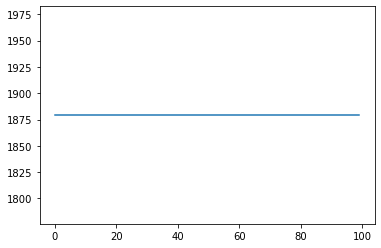

In [86]:
plt.plot(losses)

In [3]:
[x for x in dir(BRepBuilderAPI) if 'Make' in x]

['BRepBuilderAPI_MakeEdge',
 'BRepBuilderAPI_MakeEdge2d',
 'BRepBuilderAPI_MakeFace',
 'BRepBuilderAPI_MakePolygon',
 'BRepBuilderAPI_MakeShape',
 'BRepBuilderAPI_MakeShell',
 'BRepBuilderAPI_MakeSolid',
 'BRepBuilderAPI_MakeVertex',
 'BRepBuilderAPI_MakeWire']

In [10]:
plane = Geom.Geom_Plane(1.0,1.0,0.0,1.0)

In [11]:
plane

<class 'Geom_Plane'>

In [25]:
plane.Axis().Location().Z()

0.0

In [26]:
plane.Axis()

<class 'gp_Ax1'>

In [28]:
loc = gp_Pnt(0, 0, 0)
z_ax = gp_Dir(0,0,1)
x_ax = gp_Dir(1,0,0)

In [50]:
plane1 = Geom.Geom_Plane(gp_Pnt(0,0,0), gp_Dir(1,0,0))
plane2 = Geom.Geom_Plane(gp_Pnt(0,0,0), gp_Dir(0,0,1))

In [54]:
plane_intersection = OCC.Core.GeomAPI.GeomAPI_IntSS(plane1, plane2, 0.0001)
plane_intersection.IsDone()
intersection_curve = plane_intersection.Line(1)
icurve_type = intersection_curve.DynamicType()
icurve_type.Name()

True

'Geom_Line'

In [34]:
face = BRepBuilderAPI.BRepBuilderAPI_MakeFace()

In [37]:
import OCC
import OCC.Core

In [38]:

from OCC.Core.BRepPrimAPI import BRepPrimAPI_MakeBox, BRepPrimAPI_MakeSphere, BRepPrimAPI_MakeCylinder
from OCC.Core.gp import gp_Pnt

In [40]:
box_shape = BRepPrimAPI_MakeBox(10,20,30).Shape()
cylinder_shape = BRepPrimAPI_MakeCylinder(10,30).Shape()

In [ ]:
my_renderer.DisplayShape(
    cylinder_shape, 
    render_edges=True, 
    topo_level="Face", 
    shape_color="#abdda4",
    update=True)

In [44]:
import math

from OCC.Core.gp import (
    gp_Pnt,
    gp_Sphere,
    gp_Ax3,
    gp_Dir,
    gp_Circ,
    gp_Ax2,
    gp_Pnt2d,
    gp_Dir2d,
)
from OCC.Core.BRepBuilderAPI import (
    BRepBuilderAPI_MakeEdge,
    BRepBuilderAPI_MakeFace,
    BRepBuilderAPI_MakeWire,
)
from OCC.Core.TColgp import TColgp_Array2OfPnt
from OCC.Core.GeomAPI import GeomAPI_PointsToBSplineSurface
from OCC.Core.GeomAbs import GeomAbs_C2
from OCC.Core.Geom2d import Geom2d_Line
from OCC.Core.BRepLib import breplib_BuildCurves3d
from OCC.Core.Quantity import Quantity_Color, Quantity_NOC_PINK

In [ ]:
p1 = gp_Pnt()
p2 = gp_Pnt()
p3 = gp_Pnt()
p4 = gp_Pnt()
p5 = gp_Pnt()
p6 = gp_Pnt()

# The white Face
sphere = gp_Sphere(gp_Ax3(gp_Pnt(0, 0, 0), gp_Dir(1, 0, 0)), 150)
green_face = BRepBuilderAPI_MakeFace(sphere, 0.1, 0.7, 0.2, 0.9)

# The red face
p1.SetCoord(-15, 200, 10)
p2.SetCoord(5, 204, 0)
p3.SetCoord(15, 200, 0)
p4.SetCoord(-15, 20, 15)
p5.SetCoord(-5, 20, 0)
p6.SetCoord(15, 20, 35)
array = TColgp_Array2OfPnt(1, 3, 1, 2)
array.SetValue(1, 1, p1)
array.SetValue(2, 1, p2)
array.SetValue(3, 1, p3)
array.SetValue(1, 2, p4)
array.SetValue(2, 2, p5)
array.SetValue(3, 2, p6)
curve = GeomAPI_PointsToBSplineSurface(array, 3, 8, GeomAbs_C2, 0.001).Surface()
red_face = BRepBuilderAPI_MakeFace(curve, 1e-6)

# The brown face
circle = gp_Circ(gp_Ax2(gp_Pnt(0, 0, 0), gp_Dir(1, 0, 0)), 80)
Edge1 = BRepBuilderAPI_MakeEdge(circle, 0, math.pi)
Edge2 = BRepBuilderAPI_MakeEdge(gp_Pnt(0, 0, -80), gp_Pnt(0, -10, 40))
Edge3 = BRepBuilderAPI_MakeEdge(gp_Pnt(0, -10, 40), gp_Pnt(0, 0, 80))

##TopoDS_Wire YellowWire
MW1 = BRepBuilderAPI_MakeWire(Edge1.Edge(), Edge2.Edge(), Edge3.Edge())
if not MW1.IsDone():
    raise AssertionError("MW1 is not done.")
yellow_wire = MW1.Wire()
brown_face = BRepBuilderAPI_MakeFace(yellow_wire)

# The pink face
p1.SetCoord(35, -200, 40)
p2.SetCoord(50, -204, 30)
p3.SetCoord(65, -200, 30)
p4.SetCoord(35, -20, 45)
p5.SetCoord(45, -20, 30)
p6.SetCoord(65, -20, 65)
array2 = TColgp_Array2OfPnt(1, 3, 1, 2)
array2.SetValue(1, 1, p1)
array2.SetValue(2, 1, p2)
array2.SetValue(3, 1, p3)
array2.SetValue(1, 2, p4)
array2.SetValue(2, 2, p5)
array2.SetValue(3, 2, p6)
BSplineSurf = GeomAPI_PointsToBSplineSurface(array2, 3, 8, GeomAbs_C2, 0.001)
aFace = BRepBuilderAPI_MakeFace(BSplineSurf.Surface(), 1e-6).Face()
##
##//2d lines
P12d = gp_Pnt2d(0.9, 0.1)
P22d = gp_Pnt2d(0.2, 0.7)
P32d = gp_Pnt2d(0.02, 0.1)
##
line1 = Geom2d_Line(P12d, gp_Dir2d((0.2 - 0.9), (0.7 - 0.1)))
line2 = Geom2d_Line(P22d, gp_Dir2d((0.02 - 0.2), (0.1 - 0.7)))
line3 = Geom2d_Line(P32d, gp_Dir2d((0.9 - 0.02), (0.1 - 0.1)))
##
##//Edges are on the BSpline surface
Edge1 = BRepBuilderAPI_MakeEdge(
    line1, BSplineSurf.Surface(), 0, P12d.Distance(P22d)
).Edge()
Edge2 = BRepBuilderAPI_MakeEdge(
    line2, BSplineSurf.Surface(), 0, P22d.Distance(P32d)
).Edge()
Edge3 = BRepBuilderAPI_MakeEdge(
    line3, BSplineSurf.Surface(), 0, P32d.Distance(P12d)
).Edge()
##
Wire1 = BRepBuilderAPI_MakeWire(Edge1, Edge2, Edge3).Wire()
Wire1.Reverse()
pink_face = BRepBuilderAPI_MakeFace(aFace, Wire1).Face()
breplib_BuildCurves3d(pink_face)

my_renderer.DisplayShape(green_face.Face())
my_renderer.DisplayShape(red_face.Face())
my_renderer.DisplayShape(pink_face)
my_renderer.DisplayShape(brown_face.Face(),update=True)

#display.DisplayColoredShape(green_face.Face(), "GREEN")
#display.DisplayColoredShape(red_face.Face(), "RED")
#display.DisplayColoredShape(pink_face, Quantity_Color(Quantity_NOC_PINK))
#display.DisplayColoredShape(brown_face.Face(), "BLUE")
#display.DisplayColoredShape(yellow_wire, "YELLOW", update=True)